In [1]:
import numpy as np
import tensorflow.keras.backend as K
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
dataset = np.load("../../KEMDy20_v1_1/Extract/Dataset_MFCC.npz", allow_pickle=True)

In [3]:
train_x = dataset["train_x"]
train_y = dataset["train_y"]
test_x = dataset["test_x"]
test_y = dataset["test_y"]
train_aug_x = dataset["train_aug_x"]
train_aug_y = dataset["train_aug_y"]

In [4]:
def Macro_f1(y_true, y_pred):
    y_true = K.round(y_true)
    y_pred = K.round(y_pred)
    
    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1-y_true) * y_pred, axis=0)
    fn = K.sum(y_true * (1-y_pred), axis=0)
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    
    # Calculate macro F1 score
    macro_f1 = K.mean(f1)
    
    return macro_f1

In [5]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# 레이블 인코딩
le = LabelEncoder()
le.fit(train_y)
encoded_train_y = le.transform(train_y)

# 원핫 인코딩
onehot_train_y = to_categorical(encoded_train_y)

# train_y에서 사용된 LabelEncoder 객체를 그대로 사용하여 test_y 인코딩
encoded_test_y = le.transform(test_y)

# test_y를 원핫 인코딩
onehot_test_y = to_categorical(encoded_test_y)

# Split the train and test data into four parts
train_data_parts = np.split(train_x, 4, axis=1)
test_data_parts = np.split(test_x, 4, axis=1)

In [6]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Flatten, Dense, Average, Dropout, SpatialDropout1D

# Define submodel architecture
def create_submodel(input_shape):
    submodel_input = Input(shape=input_shape)
    x = Conv1D(filters=16, kernel_size=3, activation='relu')(submodel_input)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = SpatialDropout1D(rate=0.2)(x)
    x = Flatten()(x)
    x = Dense(units=256, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(units=7, activation='softmax')(x)
    return submodel_input, x

# Define the list to store submodels and input shapes
submodels = []
input_shapes = []

# Create submodels
for i in range(4):
    input_shape = train_data_parts[i].shape[1:]
    submodel_input, submodel_output = create_submodel(input_shape)
    submodels.append(Model(inputs=submodel_input, outputs=submodel_output))
    input_shapes.append(input_shape)

# Define final model architecture
inputs = [Input(shape=input_shape) for input_shape in input_shapes]
outputs = [[submodel(inputs[i])] for i, submodel in enumerate(submodels)]
merged = Average()([output[0] for output in outputs])

#merged = Dense(units=7, activation='softmax')(Flatten()(merged))
final_model = Model(inputs=inputs, outputs=merged)

# Compile the final model
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Macro_f1])

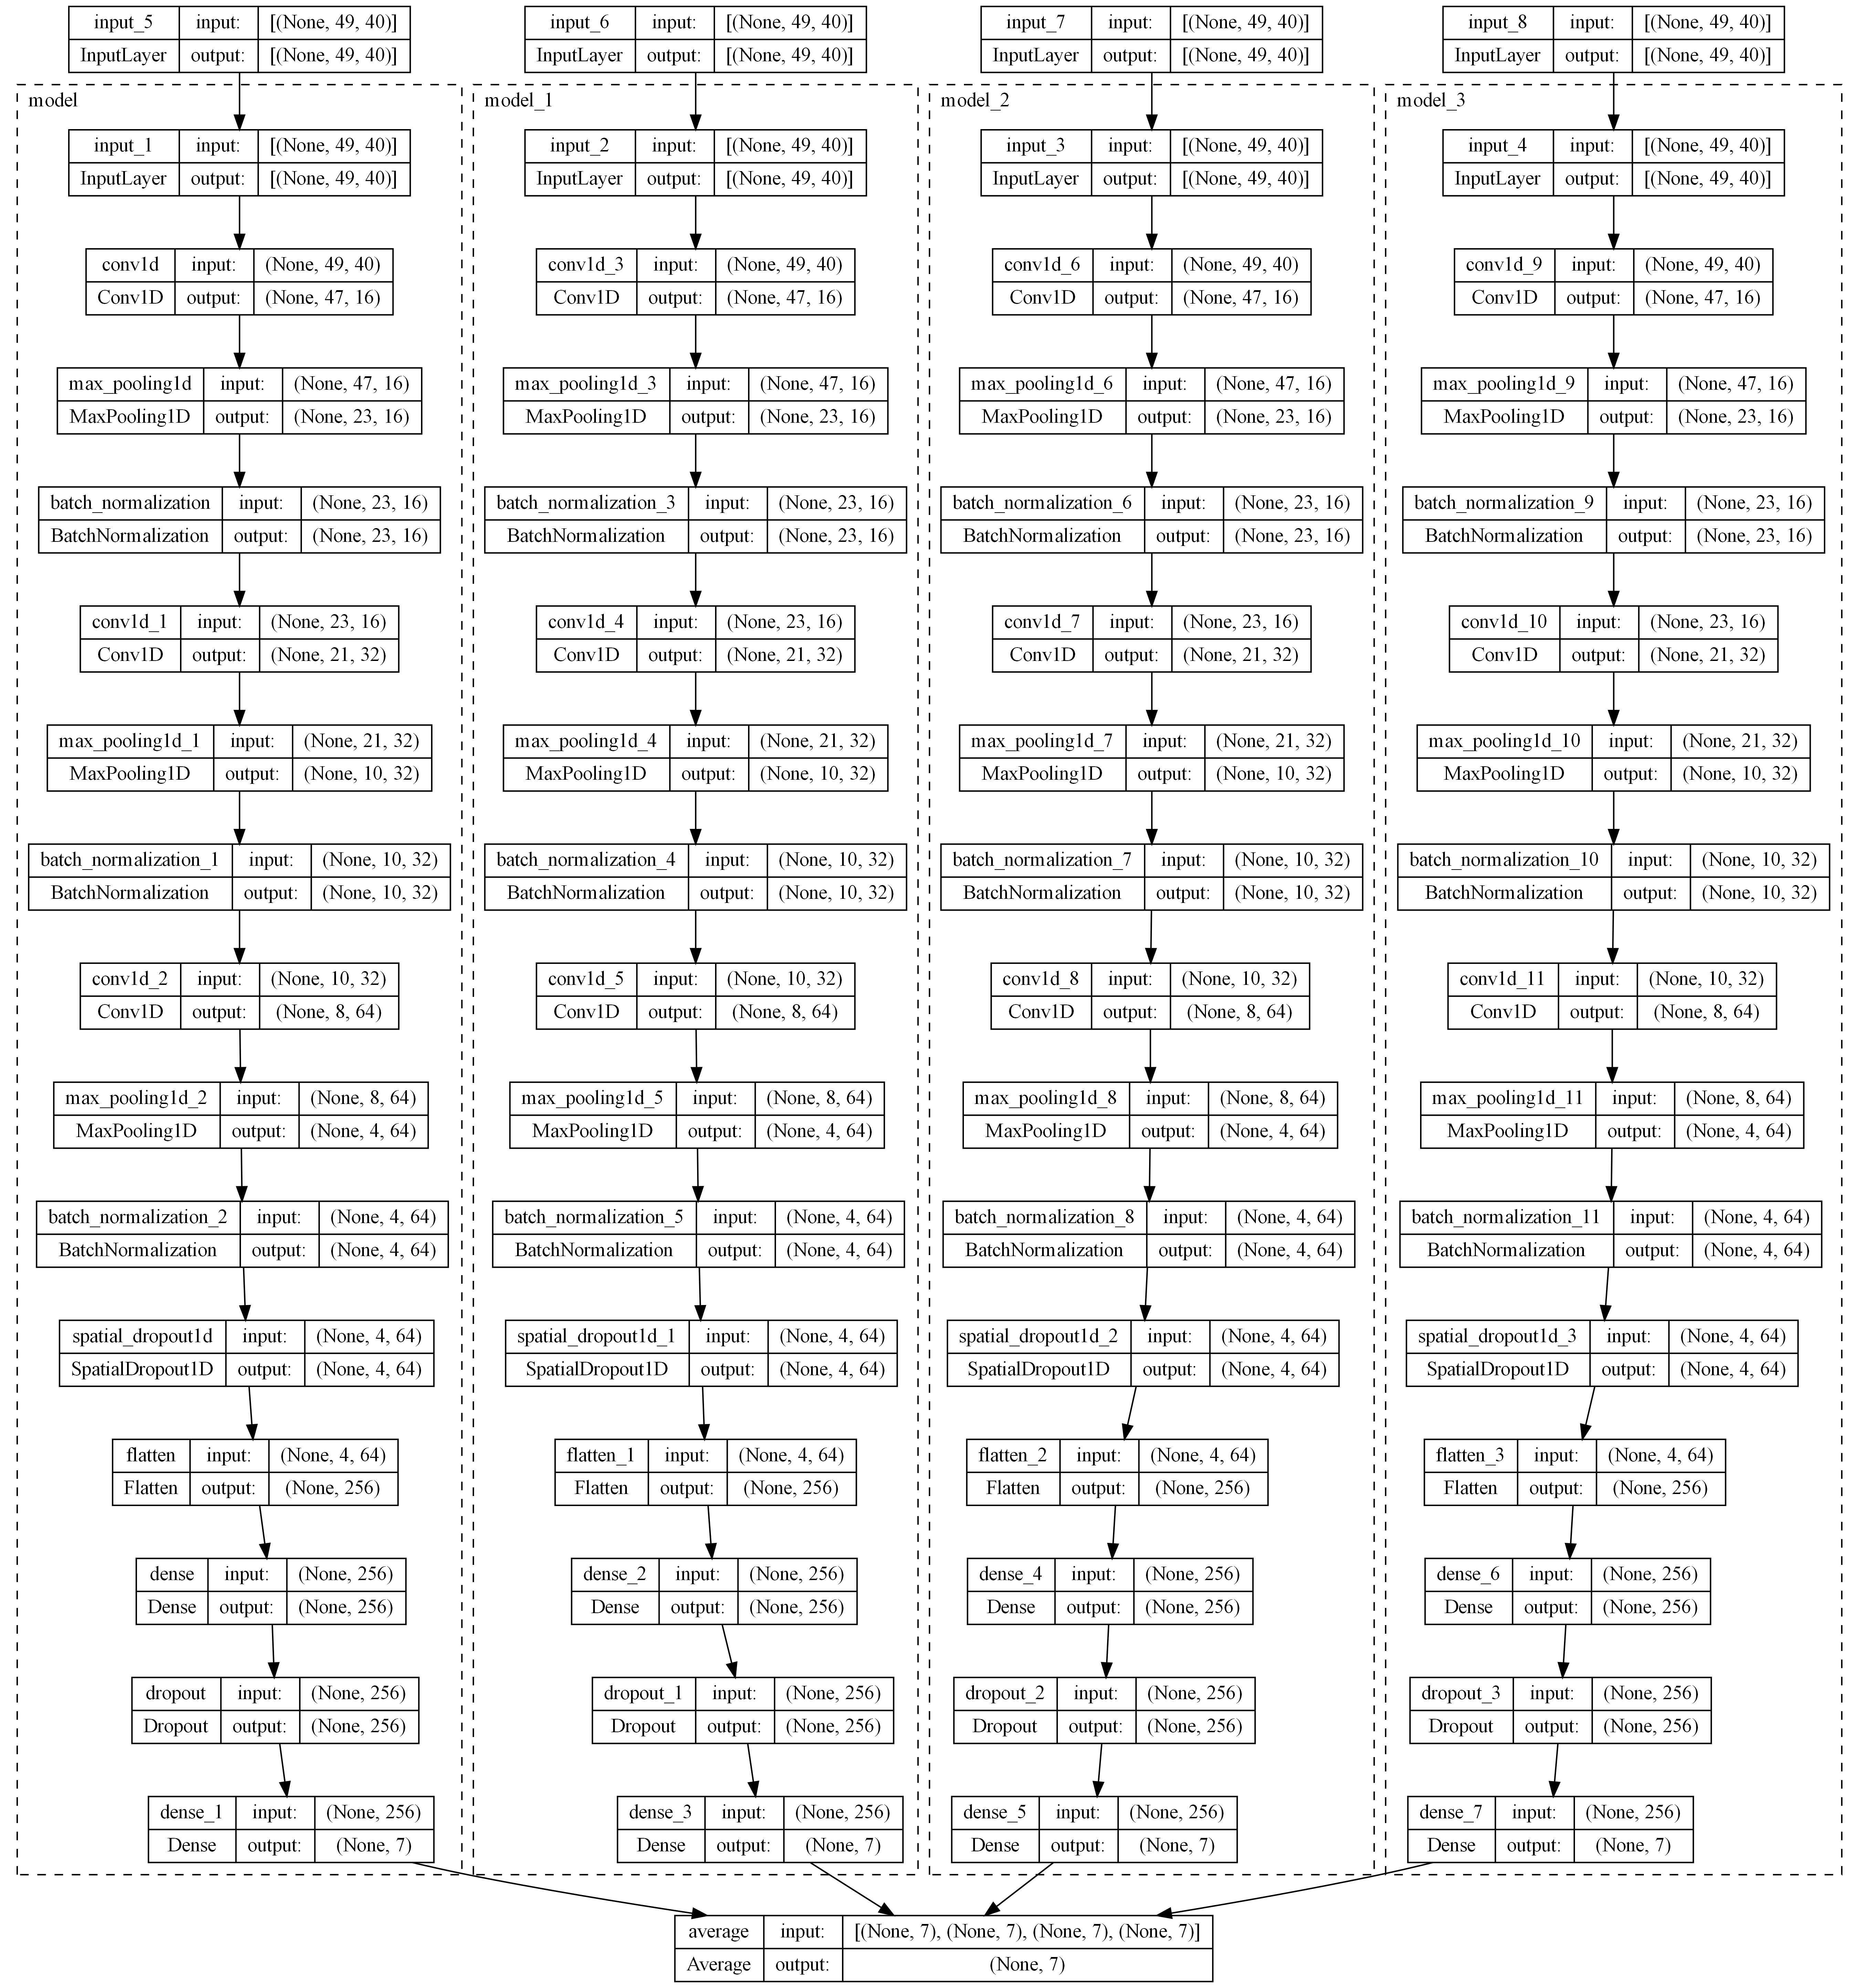

In [7]:
from keras.utils import plot_model

# Visualize final model architecture
plot_model(final_model, to_file='../final_model.png', show_shapes=True, expand_nested=True, dpi=300)

In [9]:
import os
from tensorflow.keras import callbacks

# Prepare the data for training
final_train_data = [train_data_parts[i].reshape(train_x.shape[0], -1, train_aug_x.shape[2]) for i in range(4)]
final_test_data = [test_data_parts[i].reshape(test_x.shape[0], -1, test_x.shape[2]) for i in range(4)]

save_model_path="../Model/"
weight_path=save_model_path+"Model_weights_best.hdf5"

if not os.path.exists(save_model_path):
    os.mkdir(save_model_path)

checkpoint = callbacks.ModelCheckpoint(
    weight_path,
    monitor='val_Macro_f1',
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
    mode='max'
)

# Train the final model
final_model.fit(
    final_train_data,
    onehot_train_y,
    epochs=100,
    batch_size=32,
    validation_data=(final_test_data, onehot_test_y),
    callbacks=[checkpoint]
)

# Evaluate the final model on the test data
test_loss, test_macro_f1 = final_model.evaluate(final_test_data, onehot_test_y)
print(f'Test loss: {test_loss}, test macro_f1: {test_macro_f1}')

Epoch 1/100
325/325 [==============================] - ETA: 0s - loss: 0.5401 - Macro_f1: 0.1447
Epoch 1: val_Macro_f1 improved from -inf to 0.13837, saving model to ../Model\Model_weights_best.hdf5
325/325 [==============================] - 18s 31ms/step - loss: 0.5401 - Macro_f1: 0.1447 - val_loss: 0.5710 - val_Macro_f1: 0.1384
Epoch 2/100
324/325 [============================>.] - ETA: 0s - loss: 0.4593 - Macro_f1: 0.1561
Epoch 2: val_Macro_f1 improved from 0.13837 to 0.15569, saving model to ../Model\Model_weights_best.hdf5
325/325 [==============================] - 9s 28ms/step - loss: 0.4589 - Macro_f1: 0.1560 - val_loss: 0.6199 - val_Macro_f1: 0.1557
Epoch 3/100
324/325 [============================>.] - ETA: 0s - loss: 0.4285 - Macro_f1: 0.1657
Epoch 3: val_Macro_f1 improved from 0.15569 to 0.15997, saving model to ../Model\Model_weights_best.hdf5
325/325 [==============================] - 9s 28ms/step - loss: 0.4290 - Macro_f1: 0.1656 - val_loss: 0.5630 - val_Macro_f1: 0.1600


Epoch 29/100
325/325 [==============================] - ETA: 0s - loss: 0.1919 - Macro_f1: 0.2018
Epoch 29: val_Macro_f1 did not improve from 0.17168
325/325 [==============================] - 9s 28ms/step - loss: 0.1919 - Macro_f1: 0.2018 - val_loss: 0.9346 - val_Macro_f1: 0.1620
Epoch 30/100
325/325 [==============================] - ETA: 0s - loss: 0.1919 - Macro_f1: 0.2046
Epoch 30: val_Macro_f1 did not improve from 0.17168
325/325 [==============================] - 9s 28ms/step - loss: 0.1919 - Macro_f1: 0.2046 - val_loss: 0.9112 - val_Macro_f1: 0.1583
Epoch 31/100
325/325 [==============================] - ETA: 0s - loss: 0.1846 - Macro_f1: 0.2052
Epoch 31: val_Macro_f1 did not improve from 0.17168
325/325 [==============================] - 9s 28ms/step - loss: 0.1846 - Macro_f1: 0.2052 - val_loss: 0.9223 - val_Macro_f1: 0.1658
Epoch 32/100
324/325 [============================>.] - ETA: 0s - loss: 0.1856 - Macro_f1: 0.2055
Epoch 32: val_Macro_f1 did not improve from 0.17168
325/

KeyboardInterrupt: 

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_test_data, onehot_test_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_test_data)
em = classification_report(
    np.argmax(onehot_test_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_test_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

77/77 [==============================] - 1s 10ms/step - loss: 0.8607 - Macro_f1: 0.1717
Model evaluation:  [0.8606505990028381, 0.17167651653289795]
77/77 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00        20
     disqust       0.00      0.00      0.00         3
        fear       0.00      0.00      0.00        16
       happy       0.55      0.44      0.49       250
     neutral       0.89      0.96      0.92      2077
         sad       0.00      0.00      0.00        35
    surprise       0.00      0.00      0.00        36

    accuracy                           0.86      2437
   macro avg       0.21      0.20      0.20      2437
weighted avg       0.81      0.86      0.84      2437



C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs

In [17]:
final_model.load_weights(weight_path)
best_eva_list = final_model.evaluate(final_train_data, onehot_train_y)
loss = best_eva_list[0]
macro_f1 = best_eva_list[1]
print('Model evaluation: ', best_eva_list)
y_pred_best = final_model.predict(final_train_data)
em = classification_report(
    np.argmax(onehot_train_y,axis=1),
    np.argmax(y_pred_best,axis=1),
    target_names=le.classes_,
    output_dict=True
)
print(classification_report(np.argmax(onehot_train_y,axis=1), np.argmax(y_pred_best,axis=1), target_names=le.classes_))

325/325 [==============================] - 3s 10ms/step - loss: 0.2202 - Macro_f1: 0.1928
Model evaluation:  [0.22021692991256714, 0.1928286999464035]
325/325 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

       angry       1.00      0.12      0.22       124
     disqust       1.00      0.02      0.03        58
        fear       0.00      0.00      0.00        27
       happy       0.78      0.61      0.68       933
     neutral       0.92      0.99      0.95      9043
         sad       1.00      0.05      0.09        86
    surprise       1.00      0.02      0.03       120

    accuracy                           0.91     10391
   macro avg       0.82      0.26      0.29     10391
weighted avg       0.91      0.91      0.90     10391



C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs\ETRI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Yechani\.conda\envs

In [7]:
#from sklearn.manifold import TSNE
#import matplotlib.pyplot as plt

#tsne = TSNE(n_components=2, random_state=0)
#digits_tsne = tsne.fit_transform(train_aug_x)

In [8]:
#plt.figure(figsize=(10, 8))
#plt.scatter(digits_tsne[:, 0], digits_tsne[:, 1])
#plt.colorbar()
#plt.show()